In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from scipy.special import kv, gamma
from sklearn.metrics import mean_squared_error, mean_absolute_error


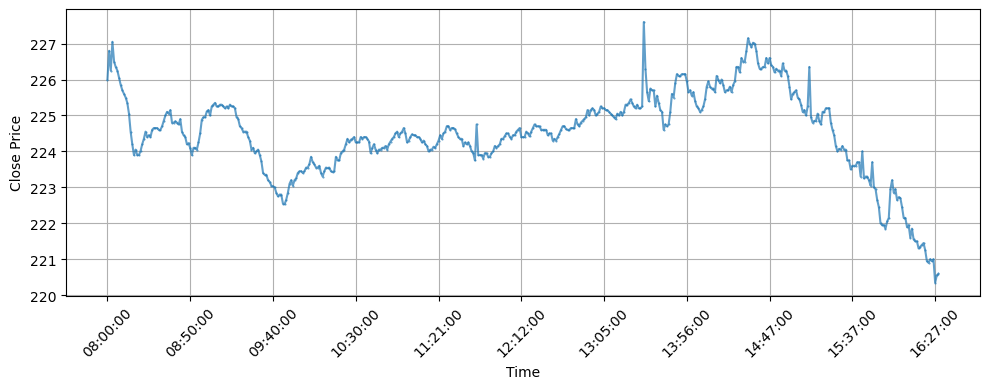

In [2]:
data=pd.read_csv("intra.csv")
data['Datetime']=pd.to_datetime(data['Datetime'])
data['Time']= data['Datetime'].dt.strftime('%H:%M:%S')

# Plotting the data
plt.figure(figsize=(10, 4))
plt.plot(data['Time'], data['Close'], marker='o', linestyle='-', markersize=0.5, alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.grid(True)
num_ticks = 10  # Adjust this number as needed
plt.xticks(ticks=range(0, len(data['Time']), len(data['Time']) // num_ticks), rotation=45)

plt.tight_layout()
plt.show()

# Section 1
This section is for mapping the intra-day data using the Squared Exponential Kernel

In [3]:
# Extract input features (X) and output targets (y)
X_train = np.array(data.index).reshape(-1, 1)  # Using the index as the input feature for simplicity
y_train = data['Close'].values

In [4]:
def squared_exponential_kernel(x1, x2, length_scale, sigma_f):
    sqdist = np.sum(x1**2, 1).reshape(-1, 1) + np.sum(x2**2, 1) - 2 * np.dot(x1, x2.T)
    return sigma_f**2 * np.exp(-0.5 / length_scale**2 * sqdist)


In [5]:
def log_marginal_likelihood(params, X_train, y_train):
    length_scale = params[0]
    sigma_f = params[1]
    sigma_y = params[2]
    
    K = squared_exponential_kernel(X_train, X_train, length_scale, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    L = np.linalg.cholesky(K)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y_train))
    
    return 0.5 * np.dot(y_train.T, alpha) + np.sum(np.log(np.diag(L))) + 0.5 * len(X_train) * np.log(2 * np.pi)


In [6]:
# Initial guesses for the hyperparameters
initial_params = [1.0, 1.0, 1e-1]

# Optimize the hyperparameters
res = minimize(log_marginal_likelihood, initial_params, args=(X_train, y_train), bounds=((1e-5, None), (1e-5, None), (1e-5, None)))

length_scale_opt, sigma_f_opt, sigma_y_opt = res.x
print(f"Optimized length scale: {length_scale_opt}, sigma_f: {sigma_f_opt}, sigma_y: {sigma_y_opt}")


Optimized length scale: 30.82943705727523, sigma_f: 80.08870058950372, sigma_y: 0.2720839620485425


In [7]:
def posterior_predictive(X_train, y_train, X_s, length_scale, sigma_f, sigma_y):
    K = squared_exponential_kernel(X_train, X_train, length_scale, sigma_f)
    K_s = squared_exponential_kernel(X_train, X_s, length_scale, sigma_f)
    K_ss = squared_exponential_kernel(X_s, X_s, length_scale, sigma_f)
    K_inv = np.linalg.inv(K + sigma_y**2 * np.eye(len(X_train)))

    mu_s = K_s.T.dot(K_inv).dot(y_train)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)

    return mu_s, cov_s

# Generate test points
X_s = np.linspace(0, len(X_train), 100).reshape(-1, 1)

# Get the posterior predictive mean and covariance
mu_s, cov_s = posterior_predictive(X_train, y_train, X_s, length_scale_opt, sigma_f_opt, sigma_y_opt)


C:\Users\ITSU\AppData\Local\Temp\ipykernel_47688\1523069297.py:9: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  posterior_samples = np.random.multivariate_normal(mu_s, cov_s, 3)


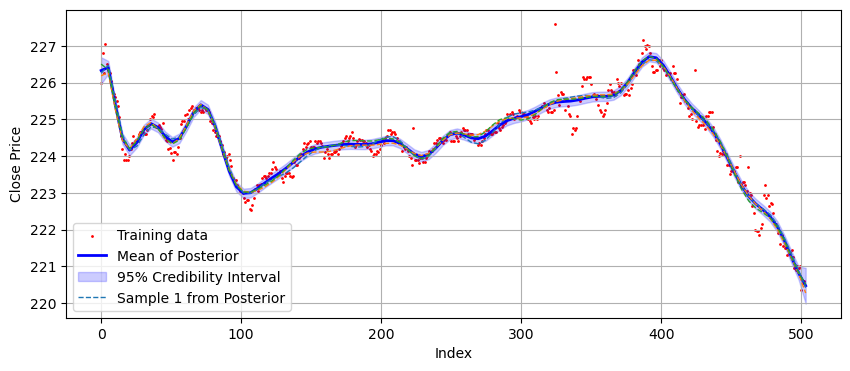

In [8]:
# Standard deviation for the 95% confidence interval
sigma_s = np.sqrt(np.diag(cov_s))

# Prior samples
K_ss = squared_exponential_kernel(X_s, X_s, length_scale_opt, sigma_f_opt)
prior_samples = np.random.multivariate_normal(np.zeros(X_s.shape[0]), K_ss, 3)

# Posterior samples
posterior_samples = np.random.multivariate_normal(mu_s, cov_s, 3)

# Plotting the results
plt.figure(figsize=(10, 4))

# Plot the training data
plt.scatter(X_train, y_train, color='red', label='Training data', s=1)

# Plot the mean of the posterior
plt.plot(X_s, mu_s, 'b-', lw=2, label='Mean of Posterior')

# Plot the 95% confidence interval
plt.fill_between(X_s.ravel(), mu_s - 1.96 * sigma_s, mu_s + 1.96 * sigma_s, color='blue', alpha=0.2, label='95% Credibility Interval')

# Plot the posterior samples as dotted lines
for i, sample in enumerate(posterior_samples):
    plt.plot(X_s, sample, linestyle='--', lw=1, label=f'Sample {i+1} from Posterior' if i == 0 else None)


plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


# Section 2
This section is for mapping the intra-day data using the Matern Kernel

Optimized length scale: 35986.48112003617, sigma_f: 32.73648988615893, sigma_y: 0.051814654686205726


C:\Users\ITSU\AppData\Local\Temp\ipykernel_47688\3243255084.py:67: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  posterior_samples = np.random.multivariate_normal(mu_s, cov_s, 3)


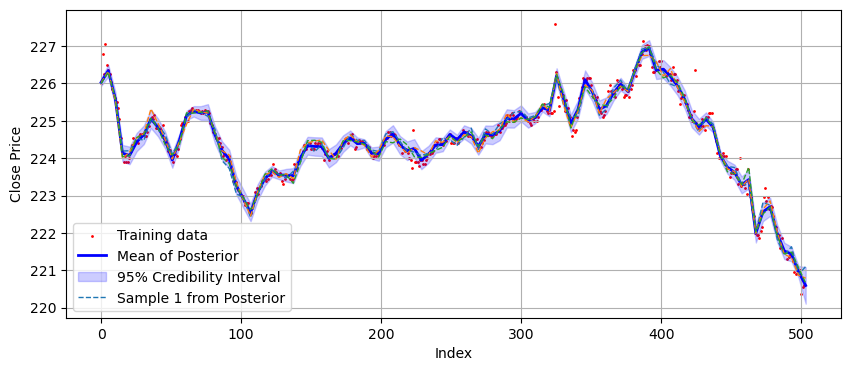

In [9]:

# Extract input features (X) and output targets (y)
X_train = np.array(data.index).reshape(-1, 1)  # Using the index as the input feature for simplicity
y_train = data['Close'].values

# Updated Matern kernel function
def matern_kernel(x1, x2, length_scale, sigma_f, nu=0.5):
    x1 = np.atleast_2d(x1)
    x2 = np.atleast_2d(x2)
    pairwise_dists = np.sqrt(np.sum((x1[:, np.newaxis] - x2[np.newaxis, :])**2, axis=-1))  # Corrected pairwise distance calculation
    factor = (np.sqrt(2 * nu) * pairwise_dists) / length_scale
    
    if nu == 0.5:
        K = np.exp(-factor)
    elif nu == 1.5:
        K = (1 + factor) * np.exp(-factor)
    elif nu == 2.5:
        K = (1 + factor + factor**2 / 3) * np.exp(-factor)
    else:
        K = (2 ** (1 - nu) / gamma(nu)) * (factor ** nu) * kv(nu, factor)
        
    return sigma_f**2 * K

# Log marginal likelihood function using Matern kernel
def log_marginal_likelihood(params, X_train, y_train, nu=0.5):
    length_scale = params[0]
    sigma_f = params[1]
    sigma_y = params[2]
    
    K = matern_kernel(X_train, X_train, length_scale, sigma_f, nu) + sigma_y**2 * np.eye(len(X_train))
    L = np.linalg.cholesky(K)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y_train))
    
    return 0.5 * np.dot(y_train.T, alpha) + np.sum(np.log(np.diag(L))) + 0.5 * len(X_train) * np.log(2 * np.pi)

# Initial guesses for the hyperparameters
initial_params = [1.0, 1.0, 1e-1]

# Optimize the hyperparameters
res = minimize(log_marginal_likelihood, initial_params, args=(X_train, y_train, 0.5), bounds=((1e-5, None), (1e-5, None), (1e-5, None)))

length_scale_opt, sigma_f_opt, sigma_y_opt = res.x
print(f"Optimized length scale: {length_scale_opt}, sigma_f: {sigma_f_opt}, sigma_y: {sigma_y_opt}")

# Posterior predictive function using Matern kernel
def posterior_predictive(X_train, y_train, X_s, length_scale, sigma_f, sigma_y, nu=0.5):
    K = matern_kernel(X_train, X_train, length_scale, sigma_f, nu)
    K_s = matern_kernel(X_train, X_s, length_scale, sigma_f, nu)
    K_ss = matern_kernel(X_s, X_s, length_scale, sigma_f, nu)
    K_inv = np.linalg.inv(K + sigma_y**2 * np.eye(len(X_train)))

    mu_s = K_s.T.dot(K_inv).dot(y_train)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)

    return mu_s, cov_s

# Get the posterior predictive mean and covariance using Matern kernel
mu_s, cov_s = posterior_predictive(X_train, y_train, X_s, length_scale_opt, sigma_f_opt, sigma_y_opt, nu=0.5)

# Standard deviation for the 95% confidence interval
sigma_s = np.sqrt(np.diag(cov_s))

# Prior samples using Matern kernel
K_ss = matern_kernel(X_s, X_s, length_scale_opt, sigma_f_opt, nu=0.5)
prior_samples = np.random.multivariate_normal(np.zeros(X_s.shape[0]), K_ss, 3)

# Posterior samples
posterior_samples = np.random.multivariate_normal(mu_s, cov_s, 3)

# Plotting the results
plt.figure(figsize=(10, 4))

# Plot the training data
plt.scatter(X_train, y_train, color='red', label='Training data', s=1)

# Plot the mean of the posterior
plt.plot(X_s, mu_s, 'b-', lw=2, label='Mean of Posterior')

# Plot the 95% confidence interval
plt.fill_between(X_s.ravel(), mu_s - 1.96 * sigma_s, mu_s + 1.96 * sigma_s, color='blue', alpha=0.2, label='95% Credibility Interval')

# Plot the posterior samples as dotted lines
for i, sample in enumerate(posterior_samples):
    plt.plot(X_s, sample, linestyle='--', lw=1, label=f'Sample {i+1} from Posterior' if i == 0 else None)


plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

# Section 3
The next section is to split the data in a static 80/10 format to train the model and make predictions.

In [10]:
# Define the portion of the data to predict
train_size = 0.8  # 80% of the data for training, 20% for testing

# Determine the split index
split_index = int(len(X_train) * train_size)

# Split the data into training and testing sets
X_train_subset = X_train[:split_index]
y_train_subset = y_train[:split_index]
X_test_subset = X_train[split_index:]  # The part you want to predict
y_test_subset = y_train[split_index:]  # True values for comparison

print(len(X_test_subset))
print(len(X_train_subset))

101
402


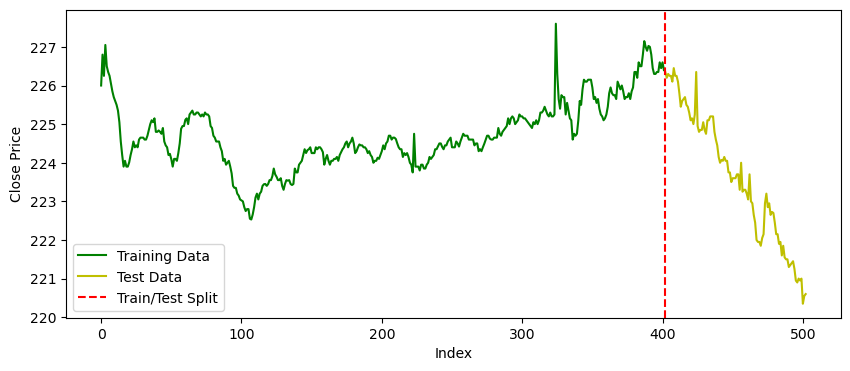

In [11]:
plt.figure(figsize=(10, 4))
plt.plot(X_train[:split_index], y_train[:split_index], 'g-', label='Training Data')

# Plot the post-split portion (test data) in another color
plt.plot(X_train[split_index:], y_train[split_index:], 'y-', label='Test Data')

# Add the vertical line for the train/test split
plt.axvline(x=split_index, color='r', linestyle='--', label='Train/Test Split')

# Additional plot details
plt.xlabel('Index')
plt.ylabel('Close Price')

plt.legend()
plt.show()

# Section 4
In this section, we will predict the test data using the SE kernel

In [12]:
def squared_exponential_kernel(x1, x2, length_scale, sigma_f):
    sqdist = np.sum(x1**2, 1).reshape(-1, 1) + np.sum(x2**2, 1) - 2 * np.dot(x1, x2.T)
    return sigma_f**2 * np.exp(-0.5 / length_scale**2 * sqdist)


In [13]:
# Define the log marginal likelihood function
def log_marginal_likelihood(params, X_train, y_train):
    length_scale = params[0]
    sigma_f = params[1]
    sigma_y = params[2]
    
    K = squared_exponential_kernel(X_train, X_train, length_scale, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    L = np.linalg.cholesky(K)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y_train))
    
    return 0.5 * np.dot(y_train.T, alpha) + np.sum(np.log(np.diag(L))) + 0.5 * len(X_train) * np.log(2 * np.pi)

# Initial guesses for the hyperparameters
initial_params = [1.0, 1.0, 1e-1]

# Optimize the hyperparameters using the log marginal likelihood function
res = minimize(log_marginal_likelihood, initial_params, args=(X_train, y_train), bounds=((1e-5, None), (1e-5, None), (1e-5, None)))

# Extract the optimized hyperparameters
length_scale_opt, sigma_f_opt, sigma_y_opt = res.x
print(f"Optimized length scale: {length_scale_opt}, sigma_f: {sigma_f_opt}, sigma_y: {sigma_y_opt}")

# Now use these optimized hyperparameters in the Gaussian Process model

Optimized length scale: 30.82943705727523, sigma_f: 80.08870058950372, sigma_y: 0.2720839620485425


In [14]:
# Compute the covariance matrix using only the training subset
K = squared_exponential_kernel(X_train_subset, X_train_subset, length_scale_opt, sigma_f_opt)


In [15]:
# Compute covariance between the training subset and the test points
K_s = squared_exponential_kernel(X_train_subset, X_test_subset, length_scale_opt, sigma_f_opt)


In [16]:
K_inv = np.linalg.inv(K + sigma_y_opt**2 * np.eye(len(X_train_subset)))

In [17]:
# Posterior mean
mu_s = K_s.T.dot(K_inv).dot(y_train_subset)
# Calculate the covariance matrix for the test points (posterior covariance)
K_ss = squared_exponential_kernel(X_test_subset, X_test_subset, length_scale_opt, sigma_f_opt)
cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)

# Standard deviation for the 95% confidence interval
sigma_s = np.sqrt(np.diag(cov_s))

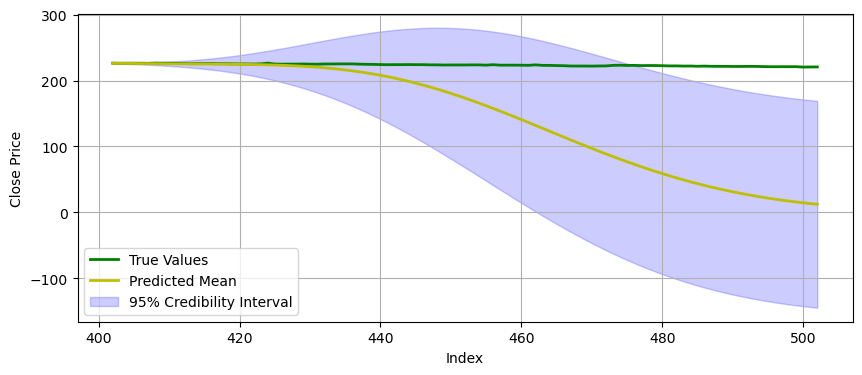

In [18]:
# Plot the true values vs predictions
plt.figure(figsize=(10, 4))

# Plot the true values
plt.plot(X_test_subset, y_test_subset, 'g-', lw=2, label='True Values')

# Plot the predicted mean
plt.plot(X_test_subset, mu_s, 'y-', lw=2, label='Predicted Mean')

# Plot the 95% confidence interval if covariance was calculated
plt.fill_between(X_test_subset.ravel(), mu_s - 1.96 * sigma_s, mu_s + 1.96 * sigma_s, color='blue', alpha=0.2, label='95% Credibility Interval')


plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

In [19]:

mape = np.mean(np.abs((y_test_subset - mu_s) / y_test_subset)) * 100
print(f"MAPE: {mape}%")

# Calculate Mean Squared Error and Mean Absolute Error
mse = mean_squared_error(y_test_subset, mu_s)
mae = mean_absolute_error(y_test_subset, mu_s)

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate the range of the test set
range_y_test = y_test_subset.max() - y_test_subset.min()

# Calculate NRMSE using the range of the test set
nrmse = rmse / range_y_test

# Calculate NMAE using the range of the test set
nmae = mae / range_y_test

# Print results
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"RMSE: {rmse}")
print(f"Range of Test Set: {range_y_test}")
print(f"NRMSE: {nrmse}")
print(f"NMAE: {nmae}")

MAPE: 34.80126857769548%
Mean Squared Error: 11792.007589678473
Mean Absolute Error: 77.27667765645147
RMSE: 108.59101063015517
Range of Test Set: 6.1002044677734375
NRMSE: 17.801208337167537
NMAE: 12.66788319386568


# Section 5
This Section is for predicting using the matern kernel

In [20]:
X = np.array(data.index).reshape(-1, 1)  # Using the index as the input feature for simplicity
y = data['Close'].values

# Perform an 80/20 split
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Debug: Print lengths of data splits
print(f"Length of X_train: {len(X_train)}, Length of y_train: {len(y_train)}")
print(f"Length of X_test: {len(X_test)}, Length of y_test: {len(y_test)}")

Length of X_train: 402, Length of y_train: 402
Length of X_test: 101, Length of y_test: 101


In [21]:
# Define the Matern kernel function
def matern_kernel(x1, x2, length_scale, sigma_f, nu=0.5):
    x1 = np.atleast_2d(x1)
    x2 = np.atleast_2d(x2)
    pairwise_dists = np.sqrt(np.sum((x1[:, np.newaxis] - x2[np.newaxis, :])**2, axis=-1))
    factor = (np.sqrt(2 * nu) * pairwise_dists) / length_scale
    
    if nu == 0.5:
        K = np.exp(-factor)
    elif nu == 1.5:
        K = (1 + factor) * np.exp(-factor)
    elif nu == 2.5:
        K = (1 + factor + factor**2 / 3) * np.exp(-factor)
    else:
        K = (2 ** (1 - nu) / gamma(nu)) * (factor ** nu) * kv(nu, factor)
        
    return sigma_f**2 * K

In [22]:
# Define the log marginal likelihood function using Matern kernel
def log_marginal_likelihood(params, X_train, y_train, nu=0.5):
    length_scale = params[0]
    sigma_f = params[1]
    sigma_y = params[2]
    
    K = matern_kernel(X_train, X_train, length_scale, sigma_f, nu) + sigma_y**2 * np.eye(len(X_train))
    L = np.linalg.cholesky(K)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y_train))
    
    return 0.5 * np.dot(y_train.T, alpha) + np.sum(np.log(np.diag(L))) + 0.5 * len(X_train) * np.log(2 * np.pi)

# Initial guesses for the hyperparameters
initial_params = [1.0, 1.0, 1e-1]

# Optimize the hyperparameters
res = minimize(log_marginal_likelihood, initial_params, args=(X_train, y_train, 0.5), bounds=((1e-5, None), (1e-5, None), (1e-5, None)))

length_scale_opt, sigma_f_opt, sigma_y_opt = res.x
print(f"Optimized length scale: {length_scale_opt}, sigma_f: {sigma_f_opt}, sigma_y: {sigma_y_opt}")

Optimized length scale: 4452.689949695686, sigma_f: 16.35602783958615, sigma_y: 1e-05


In [23]:
# Posterior predictive function using Matern kernel
def posterior_predictive(X_train, y_train, X_s, length_scale, sigma_f, sigma_y, nu=0.5):
    K = matern_kernel(X_train, X_train, length_scale, sigma_f, nu)
    K_s = matern_kernel(X_train, X_s, length_scale, sigma_f, nu)
    K_ss = matern_kernel(X_s, X_s, length_scale, sigma_f, nu)
    K_inv = np.linalg.inv(K + sigma_y**2 * np.eye(len(X_train)))

    mu_s = K_s.T.dot(K_inv).dot(y_train)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)

    return mu_s, cov_s

# Predict the 20% test set
mu_s, cov_s = posterior_predictive(X_train, y_train, X_test, length_scale_opt, sigma_f_opt, sigma_y_opt, nu=0.5)

# Debug: Check the length of mu_s
print(f"Length of mu_s (predictions): {len(mu_s)}")

# Standard deviation for the 95% confidence interval
sigma_s = np.sqrt(np.diag(cov_s))

# Ensure `mu_s` and `y_test` are of the same length
if len(mu_s) != len(y_test):
    print("Mismatch in lengths between mu_s and y_test. Check data.")
    print(f"Length of y_test: {len(y_test)}, Length of mu_s: {len(mu_s)}")

mape = np.mean(np.abs((y_test - mu_s) / y_test)) * 100
print(f"MAPE: {mape}%")

# Calculate Mean Squared Error and Mean Absolute Error
mse = mean_squared_error(y_test, mu_s)
mae = mean_absolute_error(y_test, mu_s)

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate the range of the test set
range_y_test = y_test.max() - y_test.min()

# Calculate NRMSE using the range of the test set
nrmse = rmse / range_y_test

# Calculate NMAE using the range of the test set
nmae = mae / range_y_test

# Print results
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"RMSE: {rmse}")
print(f"Range of Test Set: {range_y_test}")
print(f"NRMSE: {nrmse}")
print(f"NMAE: {nmae}")

Length of mu_s (predictions): 101
MAPE: 0.1536410072510968%
Mean Squared Error: 0.1882018656521538
Mean Absolute Error: 0.3424537209097652
RMSE: 0.4338223895238163
Range of Test Set: 6.1002044677734375
NRMSE: 0.07111604075168985
NMAE: 0.05613807253820791


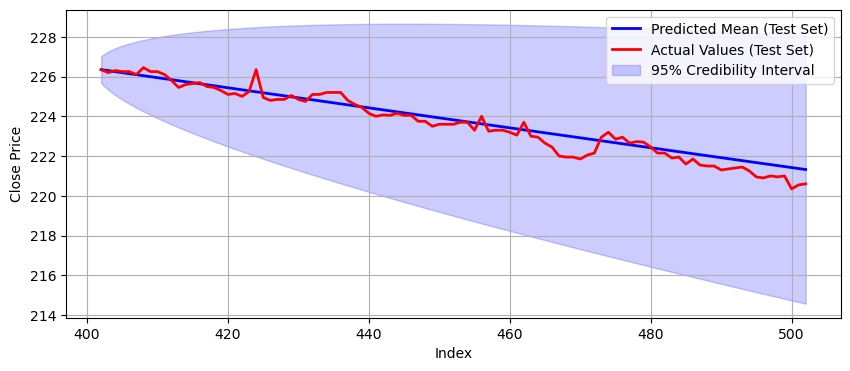

In [24]:
plt.figure(figsize=(10, 4))

# Plot the mean of the posterior for the test set
plt.plot(X_test, mu_s, 'b-', lw=2, label='Predicted Mean (Test Set)')

# Plot the actual test values
plt.plot(X_test, y_test, 'r-', lw=2, label='Actual Values (Test Set)')

# Plot the 95% confidence interval
plt.fill_between(X_test.ravel(), mu_s - 1.96 * sigma_s, mu_s + 1.96 * sigma_s, color='blue', alpha=0.2, label='95% Credibility Interval')



plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

# Section 6
In this section, we change the mean function from zero to the constant average value of the stock prices. The covariance is computed using the SE kernel

Mean: 224.42152390532394
Optimized length scale: 21.962067473963586, sigma_f: 95.55057160204711, sigma_y: 0.21557852760773014


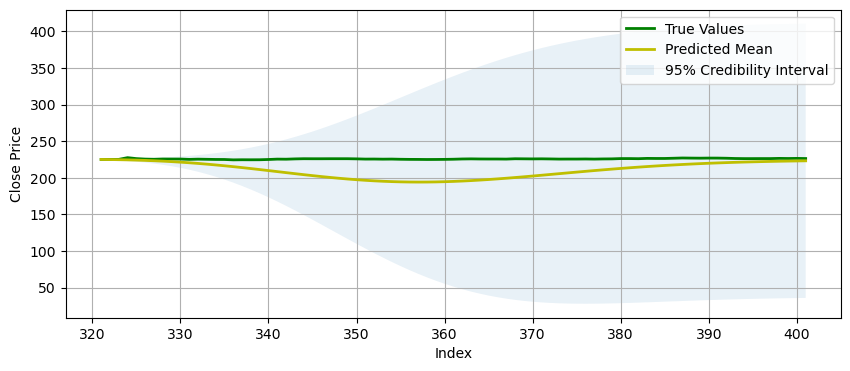

In [25]:
# Define the portion of the data to predict
train_size = 0.8  

# Determine the split index
split_index = int(len(X_train) * train_size)

# Split the data into training and testing sets
X_train_subset = X_train[:split_index]
y_train_subset = y_train[:split_index]
X_test_subset = X_train[split_index:]  # The part you want to predict
y_test_subset = y_train[split_index:]  # True values for comparison

def squared_exponential_kernel(x1, x2, length_scale, sigma_f):
    sqdist = np.sum(x1**2, 1).reshape(-1, 1) + np.sum(x2**2, 1) - 2 * np.dot(x1, x2.T)
    return sigma_f**2 * np.exp(-0.5 / length_scale**2 * sqdist)
# Calculate the mean of the training data
mean_y_train = np.mean(y_train_subset)
print(f"Mean: {mean_y_train}")

# Define the constant mean function (for future use if needed)
def mean_function(X, mean_value):
    return mean_value * np.ones(X.shape[0])

# Subtract the mean from the training data to make it zero-centered
y_train_centered = y_train_subset - mean_y_train

# Define the log marginal likelihood function
def log_marginal_likelihood(params, X_train, y_train):
    length_scale = params[0]
    sigma_f = params[1]
    sigma_y = params[2]
    
    K = squared_exponential_kernel(X_train, X_train, length_scale, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    L = np.linalg.cholesky(K)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y_train))
    
    return 0.5 * np.dot(y_train.T, alpha) + np.sum(np.log(np.diag(L))) + 0.5 * len(X_train) * np.log(2 * np.pi)

# Initial guesses for the hyperparameters
initial_params = [1.0, 1.0, 1e-1]

# Optimize the hyperparameters using the log marginal likelihood function
res = minimize(log_marginal_likelihood, initial_params, args=(X_train, y_train), bounds=((1e-5, None), (1e-5, None), (1e-5, None)))

# Extract the optimized hyperparameters
length_scale_opt, sigma_f_opt, sigma_y_opt = res.x
print(f"Optimized length scale: {length_scale_opt}, sigma_f: {sigma_f_opt}, sigma_y: {sigma_y_opt}")

# Now use these optimized hyperparameters in the Gaussian Process model

K = squared_exponential_kernel(X_train_subset, X_train_subset, length_scale_opt, sigma_f_opt)
# Compute covariance between the training subset and the test points
K_s = squared_exponential_kernel(X_train_subset, X_test_subset, length_scale_opt, sigma_f_opt)
K_inv = np.linalg.inv(K + sigma_y_opt**2 * np.eye(len(X_train_subset)))

# Posterior mean for the centered data
mu_s_centered = K_s.T.dot(K_inv).dot(y_train_centered)

# Add the constant mean back to the predictions to get the actual posterior mean
mu_s = mu_s_centered + mean_y_train

# Calculate the covariance matrix for the test points (posterior covariance)
K_ss = squared_exponential_kernel(X_test_subset, X_test_subset, length_scale_opt, sigma_f_opt)
cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)

# Standard deviation for the 95% confidence interval
sigma_s = np.sqrt(np.diag(cov_s))

# Plot the true values vs predictions
plt.figure(figsize=(10, 4))

# Plot the true values
plt.plot(X_test_subset, y_test_subset, 'g-', lw=2, label='True Values')

# Plot the predicted mean
plt.plot(X_test_subset, mu_s, 'y-', lw=2, label='Predicted Mean')

plt.fill_between(X_test_subset.ravel(), mu_s - 1.96 * sigma_s, mu_s + 1.96 * sigma_s, alpha=0.1, label='95% Credibility Interval')



plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
mape = np.mean(np.abs((y_test_subset - mu_s) / y_test_subset)) * 100
print(f"MAPE: {mape}%")

# Calculate Mean Squared Error and Mean Absolute Error
mse = mean_squared_error(y_test_subset, mu_s)
mae = mean_absolute_error(y_test_subset, mu_s)

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate the range of the test set
range_y_test = y_test_subset.max() - y_test_subset.min()

# Calculate NRMSE using the range of the test set
nrmse = rmse / range_y_test

# Calculate NMAE using the range of the test set
nmae = mae / range_y_test

# Print results
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"RMSE: {rmse}")
print(f"Range of Test Set: {range_y_test}")
print(f"NRMSE: {nrmse}")
print(f"NMAE: {nmae}")

MAPE: 6.807910027144666%
Mean Squared Error: 342.72699535370776
Mean Absolute Error: 15.370810753189426
RMSE: 18.512887277615768
Range of Test Set: 3.0
NRMSE: 6.170962425871923
NMAE: 5.123603584396475


# Section 7
In this section, we change the mean function from zero to the constant average value of the stock prices. The covariance is computed using the matern kernel

Length of X_train: 402, Length of y_train: 402
Length of X_test: 101, Length of y_test: 101
Optimized length scale: 60.40032332351051, sigma_f: 1.0001419404599634, sigma_y: 0.08662174622324581


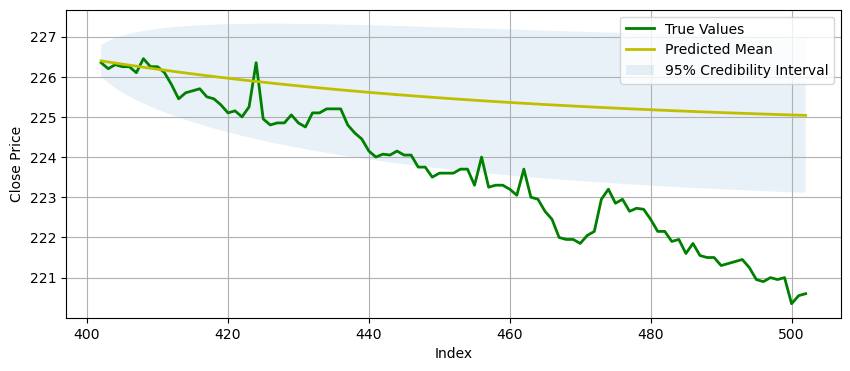

In [27]:


# Extract input features (X) and output targets (y)
X_train = np.array(data.index).reshape(-1, 1)  # Using the index as the input feature for simplicity
y_train = data['Close'].values


# Perform an 80/20 split
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Debug: Print lengths of data splits
print(f"Length of X_train: {len(X_train)}, Length of y_train: {len(y_train)}")
print(f"Length of X_test: {len(X_test)}, Length of y_test: {len(y_test)}")

# Calculate the mean of the training data
mean_y_train = np.mean(y_train)

# Subtract the mean from y_train to make it zero-centered
y_train_centered = y_train - mean_y_train

# Define the Matern kernel function
def matern_kernel(x1, x2, length_scale, sigma_f, nu=0.5):
    x1 = np.atleast_2d(x1)
    x2 = np.atleast_2d(x2)
    pairwise_dists = np.sqrt(np.sum((x1[:, np.newaxis] - x2[np.newaxis, :])**2, axis=-1))
    factor = (np.sqrt(2 * nu) * pairwise_dists) / length_scale
    
    if nu == 0.5:
        K = np.exp(-factor)
    elif nu == 1.5:
        K = (1 + factor) * np.exp(-factor)
    elif nu == 2.5:
        K = (1 + factor + factor**2 / 3) * np.exp(-factor)
    else:
        K = (2 ** (1 - nu) / gamma(nu)) * (factor ** nu) * kv(nu, factor)
        
    return sigma_f**2 * K

# Define the log marginal likelihood function using Matern kernel
def log_marginal_likelihood(params, X_train, y_train_centered, nu=0.5):
    length_scale = params[0]
    sigma_f = params[1]
    sigma_y = params[2]
    
    K = matern_kernel(X_train, X_train, length_scale, sigma_f, nu) + sigma_y**2 * np.eye(len(X_train))
    L = np.linalg.cholesky(K)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y_train_centered))
    
    return 0.5 * np.dot(y_train_centered.T, alpha) + np.sum(np.log(np.diag(L))) + 0.5 * len(X_train) * np.log(2 * np.pi)

# Initial guesses for the hyperparameters
initial_params = [1.0, 1.0, 1e-1]

# Optimize the hyperparameters
res = minimize(log_marginal_likelihood, initial_params, args=(X_train, y_train_centered, 0.5), bounds=((1e-5, None), (1e-5, None), (1e-5, None)))

length_scale_opt, sigma_f_opt, sigma_y_opt = res.x
print(f"Optimized length scale: {length_scale_opt}, sigma_f: {sigma_f_opt}, sigma_y: {sigma_y_opt}")

# Posterior predictive function using Matern kernel
def posterior_predictive(X_train, y_train_centered, X_s, length_scale, sigma_f, sigma_y, nu=0.5):
    K = matern_kernel(X_train, X_train, length_scale, sigma_f, nu)
    K_s = matern_kernel(X_train, X_s, length_scale, sigma_f, nu)
    K_ss = matern_kernel(X_s, X_s, length_scale, sigma_f, nu)
    K_inv = np.linalg.inv(K + sigma_y**2 * np.eye(len(X_train)))

    mu_s_centered = K_s.T.dot(K_inv).dot(y_train_centered)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)

    # Add the constant mean back to the predictions
    mu_s = mu_s_centered + mean_y_train

    return mu_s, cov_s

# Predict the 20% test set
mu_s, cov_s = posterior_predictive(X_train, y_train_centered, X_test, length_scale_opt, sigma_f_opt, sigma_y_opt, nu=0.5)

# Standard deviation for the 95% confidence interval
sigma_s = np.sqrt(np.diag(cov_s))

# Plot the true values vs predictions
plt.figure(figsize=(10, 4))

# Plot the true values
plt.plot(X_test, y_test, 'g-', lw=2, label='True Values')

# Plot the predicted mean
plt.plot(X_test, mu_s, 'y-', lw=2, label='Predicted Mean')

plt.fill_between(X_test.ravel(), mu_s - 1.96 * sigma_s, mu_s + 1.96 * sigma_s, alpha=0.1, label='95% Credibility Interval')


plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


In [28]:
mape = np.mean(np.abs((y_test - mu_s) / y_test)) * 100
print(f"MAPE: {mape}%")

# Calculate Mean Squared Error and Mean Absolute Error
mse = mean_squared_error(y_test, mu_s)
mae = mean_absolute_error(y_test, mu_s)

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate the range of the test set
range_y_test = y_test.max() - y_test.min()

# Calculate NRMSE using the range of the test set
nrmse = rmse / range_y_test

# Calculate NMAE using the range of the test set
nmae = mae / range_y_test

# Print results
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"RMSE: {rmse}")
print(f"Range of Test Set: {range_y_test}")
print(f"NRMSE: {nrmse}")
print(f"NMAE: {nmae}")

MAPE: 0.8631084295584078%
Mean Squared Error: 5.397526368964005
Mean Absolute Error: 1.9202268890688774
RMSE: 2.3232577061023614
Range of Test Set: 6.1002044677734375
NRMSE: 0.38084915323344004
NMAE: 0.31478074205761114


# Section 8
In this section, we change the mean function from zero to the constant average value of the stock prices. The covariance is computed using the matern and white noise kernel

Length of X_train: 402, Length of y_train: 402
Length of X_test: 101, Length of y_test: 101
Optimized length scale: 60.42421714536134, sigma_f: 1.0005442775985665, sigma_y: 0.08480636360196696, sigma_noise: 0.017502850161760605


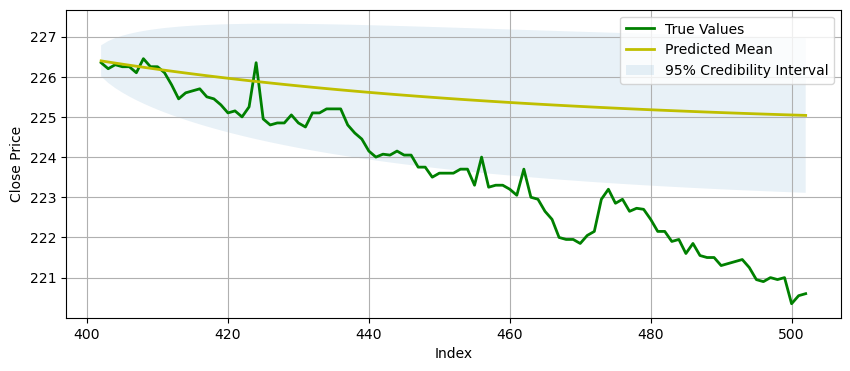

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.special import kv, gamma
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Extract input features (X) and output targets (y)
X_train = np.array(data.index).reshape(-1, 1)  # Using the index as the input feature for simplicity
y_train = data['Close'].values

# Perform a 80/20 split
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Debug: Print lengths of data splits
print(f"Length of X_train: {len(X_train)}, Length of y_train: {len(y_train)}")
print(f"Length of X_test: {len(X_test)}, Length of y_test: {len(y_test)}")

# Calculate the mean of the training data
mean_y_train = np.mean(y_train)

# Subtract the mean from y_train to make it zero-centered
y_train_centered = y_train - mean_y_train

# Define the Matérn kernel function
def matern_kernel(x1, x2, length_scale, sigma_f, nu=0.5):
    x1 = np.atleast_2d(x1)
    x2 = np.atleast_2d(x2)
    pairwise_dists = np.sqrt(np.sum((x1[:, np.newaxis] - x2[np.newaxis, :])**2, axis=-1))
    factor = (np.sqrt(2 * nu) * pairwise_dists) / length_scale
    
    if nu == 0.5:
        K = np.exp(-factor)
    elif nu == 1.5:
        K = (1 + factor) * np.exp(-factor)
    elif nu == 2.5:
        K = (1 + factor + factor**2 / 3) * np.exp(-factor)
    else:
        K = (2 ** (1 - nu) / gamma(nu)) * (factor ** nu) * kv(nu, factor)
        
    return sigma_f**2 * K

# Define the log marginal likelihood function using the Matérn kernel with white noise kernel
def log_marginal_likelihood(params, X_train, y_train_centered, nu=0.5):
    length_scale = params[0]
    sigma_f = params[1]
    sigma_y = params[2]
    sigma_noise = params[3]
    
    # Matérn kernel + white noise kernel
    K = matern_kernel(X_train, X_train, length_scale, sigma_f, nu) + sigma_noise**2 * np.eye(len(X_train)) + sigma_y**2 * np.eye(len(X_train))
    
    # Cholesky decomposition for solving the linear system
    L = np.linalg.cholesky(K)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y_train_centered))
    
    return 0.5 * np.dot(y_train_centered.T, alpha) + np.sum(np.log(np.diag(L))) + 0.5 * len(X_train) * np.log(2 * np.pi)

# Initial guesses for the hyperparameters
initial_params = [1.0, 1.0, 1e-1, 1e-2]  # Including initial guess for sigma_noise

# Optimize the hyperparameters (including white noise)
res = minimize(log_marginal_likelihood, initial_params, args=(X_train, y_train_centered, 0.5), bounds=((1e-5, None), (1e-5, None), (1e-5, None), (1e-5, None)))

# Extract optimized parameters
length_scale_opt, sigma_f_opt, sigma_y_opt, sigma_noise_opt = res.x
print(f"Optimized length scale: {length_scale_opt}, sigma_f: {sigma_f_opt}, sigma_y: {sigma_y_opt}, sigma_noise: {sigma_noise_opt}")

# Posterior predictive function with white noise kernel
def posterior_predictive(X_train, y_train_centered, X_s, length_scale, sigma_f, sigma_y, sigma_noise, nu=0.5):
    K = matern_kernel(X_train, X_train, length_scale, sigma_f, nu) + sigma_noise**2 * np.eye(len(X_train)) + sigma_y**2 * np.eye(len(X_train))
    K_s = matern_kernel(X_train, X_s, length_scale, sigma_f, nu)
    K_ss = matern_kernel(X_s, X_s, length_scale, sigma_f, nu) + sigma_noise**2 * np.eye(len(X_s))
    K_inv = np.linalg.inv(K)

    mu_s_centered = K_s.T.dot(K_inv).dot(y_train_centered)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)

    # Add the constant mean back to the predictions
    mu_s = mu_s_centered + mean_y_train

    return mu_s, cov_s

# Predict the 20% test set
mu_s, cov_s = posterior_predictive(X_train, y_train_centered, X_test, length_scale_opt, sigma_f_opt, sigma_y_opt, sigma_noise_opt, nu=0.5)

# Standard deviation for the 95% confidence interval
sigma_s = np.sqrt(np.diag(cov_s))

# Plot the true values vs predictions
plt.figure(figsize=(10, 4))

# Plot the true values
plt.plot(X_test, y_test, 'g-', lw=2, label='True Values')

# Plot the predicted mean
plt.plot(X_test, mu_s, 'y-', lw=2, label='Predicted Mean')

plt.fill_between(X_test.ravel(), mu_s - 1.96 * sigma_s, mu_s + 1.96 * sigma_s, alpha=0.1, label='95% Credibility Interval')


plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


In [30]:
mape = np.mean(np.abs((y_test - mu_s) / y_test)) * 100
print(f"MAPE: {mape}%")

# Calculate Mean Squared Error and Mean Absolute Error
mse = mean_squared_error(y_test, mu_s)
mae = mean_absolute_error(y_test, mu_s)

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate the range of the test set
range_y_test = y_test.max() - y_test.min()

# Calculate NRMSE using the range of the test set
nrmse = rmse / range_y_test

# Calculate NMAE using the range of the test set
nmae = mae / range_y_test

# Print results
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"RMSE: {rmse}")
print(f"Range of Test Set: {range_y_test}")
print(f"NRMSE: {nrmse}")
print(f"NMAE: {nmae}")


MAPE: 0.863193033041638%
Mean Squared Error: 5.398383300305693
Mean Absolute Error: 1.9204156549146025
RMSE: 2.3234421232958855
Range of Test Set: 6.1002044677734375
NRMSE: 0.38087938454691456
NMAE: 0.3148116862409942


# Section 9
In this section, fixed on the previous model, we examine the performance of the model over different folds of the data (whilst respecting the temporal nature of the data)

In [31]:

from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit


# Extract input features (X) and output targets (y)
X = np.array(data.index).reshape(-1, 1)  # Using the index as the input feature for simplicity
y = data['Close'].values

# Calculate the mean of the data (for zero-centering)
mean_y = np.mean(y)

# Subtract the mean from y to make it zero-centered
y_centered = y - mean_y

# Define the Matérn kernel function
def matern_kernel(x1, x2, length_scale, sigma_f, nu=0.5):
    x1 = np.atleast_2d(x1)
    x2 = np.atleast_2d(x2)
    pairwise_dists = np.sqrt(np.sum((x1[:, np.newaxis] - x2[np.newaxis, :])**2, axis=-1))
    factor = (np.sqrt(2 * nu) * pairwise_dists) / length_scale
    
    if nu == 0.5:
        K = np.exp(-factor)
    elif nu == 1.5:
        K = (1 + factor) * np.exp(-factor)
    elif nu == 2.5:
        K = (1 + factor + factor**2 / 3) * np.exp(-factor)
    else:
        K = (2 ** (1 - nu) / gamma(nu)) * (factor ** nu) * kv(nu, factor)
        
    return sigma_f**2 * K

# Define the log marginal likelihood function using the Matérn kernel with white noise kernel
def log_marginal_likelihood(params, X_train, y_train_centered, nu=0.5):
    length_scale = params[0]
    sigma_f = params[1]
    sigma_y = params[2]
    sigma_noise = params[3]
    
    # Matérn kernel + white noise kernel
    K = matern_kernel(X_train, X_train, length_scale, sigma_f, nu) + sigma_noise**2 * np.eye(len(X_train)) + sigma_y**2 * np.eye(len(X_train))
    
    # Cholesky decomposition for solving the linear system
    L = np.linalg.cholesky(K)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y_train_centered))
    
    return 0.5 * np.dot(y_train_centered.T, alpha) + np.sum(np.log(np.diag(L))) + 0.5 * len(X_train) * np.log(2 * np.pi)

# Posterior predictive function with white noise kernel
def posterior_predictive(X_train, y_train_centered, X_s, length_scale, sigma_f, sigma_y, sigma_noise, nu=0.5):
    K = matern_kernel(X_train, X_train, length_scale, sigma_f, nu) + sigma_noise**2 * np.eye(len(X_train)) + sigma_y**2 * np.eye(len(X_train))
    K_s = matern_kernel(X_train, X_s, length_scale, sigma_f, nu)
    K_ss = matern_kernel(X_s, X_s, length_scale, sigma_f, nu) + sigma_noise**2 * np.eye(len(X_s))
    K_inv = np.linalg.inv(K)

    mu_s_centered = K_s.T.dot(K_inv).dot(y_train_centered)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)

    # Add the constant mean back to the predictions
    mu_s = mu_s_centered + mean_y

    return mu_s, cov_s

# Set up 3-fold cross-validation
tscv = TimeSeriesSplit(n_splits=3)


# Store performance metrics
mse_scores = []
mae_scores = []
nmae_scores = []
nrmse_scores = []

# Store predictions for visualizations
y_true_all_folds = []
y_pred_all_folds = []

# Loop over each fold
for fold, (train_index, test_index) in enumerate(tscv.split(X), 1): 
    # Split into training and testing data
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    if fold == 4:
        print(f"\nFold 1 Test Indices: {test_index}")
        print(f"\nFold 1 Test Data (y_test): {y_test}")
        
    # Zero-center the y_train data
    mean_y_train = np.mean(y_train)
    y_train_centered = y_train - mean_y_train

    # Initial guesses for the hyperparameters
    initial_params = [1.0, 1.0, 1e-1, 1e-2]  # Including initial guess for sigma_noise

    # Optimize the hyperparameters (including white noise)
    res = minimize(log_marginal_likelihood, initial_params, args=(X_train, y_train_centered, 2.5), bounds=((1e-5, None), (1e-5, None), (1e-5, None), (1e-5, None)))

    # Extract optimized parameters
    length_scale_opt, sigma_f_opt, sigma_y_opt, sigma_noise_opt = res.x

    # Predict on the test set
    mu_s, cov_s = posterior_predictive(X_train, y_train_centered, X_test, length_scale_opt, sigma_f_opt, sigma_y_opt, sigma_noise_opt, nu=2.5)

    # Compute performance metrics
    mse = mean_squared_error(y_test, mu_s)
    mae = mean_absolute_error(y_test, mu_s)
    rmse = np.sqrt(mse)
    
    # Calculate normalization factor (you can choose between range or variance)
    range_y_test = y_test.max() - y_test.min()  # Using range for normalization
    
    # Compute NMAE and NRMSE
    nmae = mae / range_y_test  
    nrmse = rmse / range_y_test   # Normalized by range
    
    # Store the scores for this fold
    mse_scores.append(mse)
    mae_scores.append(mae)
    nmae_scores.append(nmae)
    nrmse_scores.append(nrmse)
    
    # Store true and predicted values for visualizations
    y_true_all_folds.append(y_test)
    y_pred_all_folds.append(mu_s)
    
    print(f"\nFold {fold}: MSE = {mse:.4f}, MAE = {mae:.4f}, NMAE = {nmae:.4f}, NRMSE = {nrmse:.4f}")

# Output the mean performance across all folds
print(f"\nAverage MSE across folds: {np.mean(mse_scores):.4f}")
print(f"Average MAE across folds: {np.mean(mae_scores):.4f}")
print(f"Average NMAE across folds: {np.mean(nmae_scores):.4f}")
print(f"Average NRMSE across folds: {np.mean(nrmse_scores):.4f}")
    
    





Fold 1: MSE = 0.0973, MAE = 0.2508, NMAE = 0.1730, NRMSE = 0.2151

Fold 2: MSE = 0.7956, MAE = 0.7239, NMAE = 0.2193, NRMSE = 0.2703

Fold 3: MSE = 3.4748, MAE = 1.5937, NMAE = 0.2344, NRMSE = 0.2741

Average MSE across folds: 1.4559
Average MAE across folds: 0.8561
Average NMAE across folds: 0.2089
Average NRMSE across folds: 0.2532


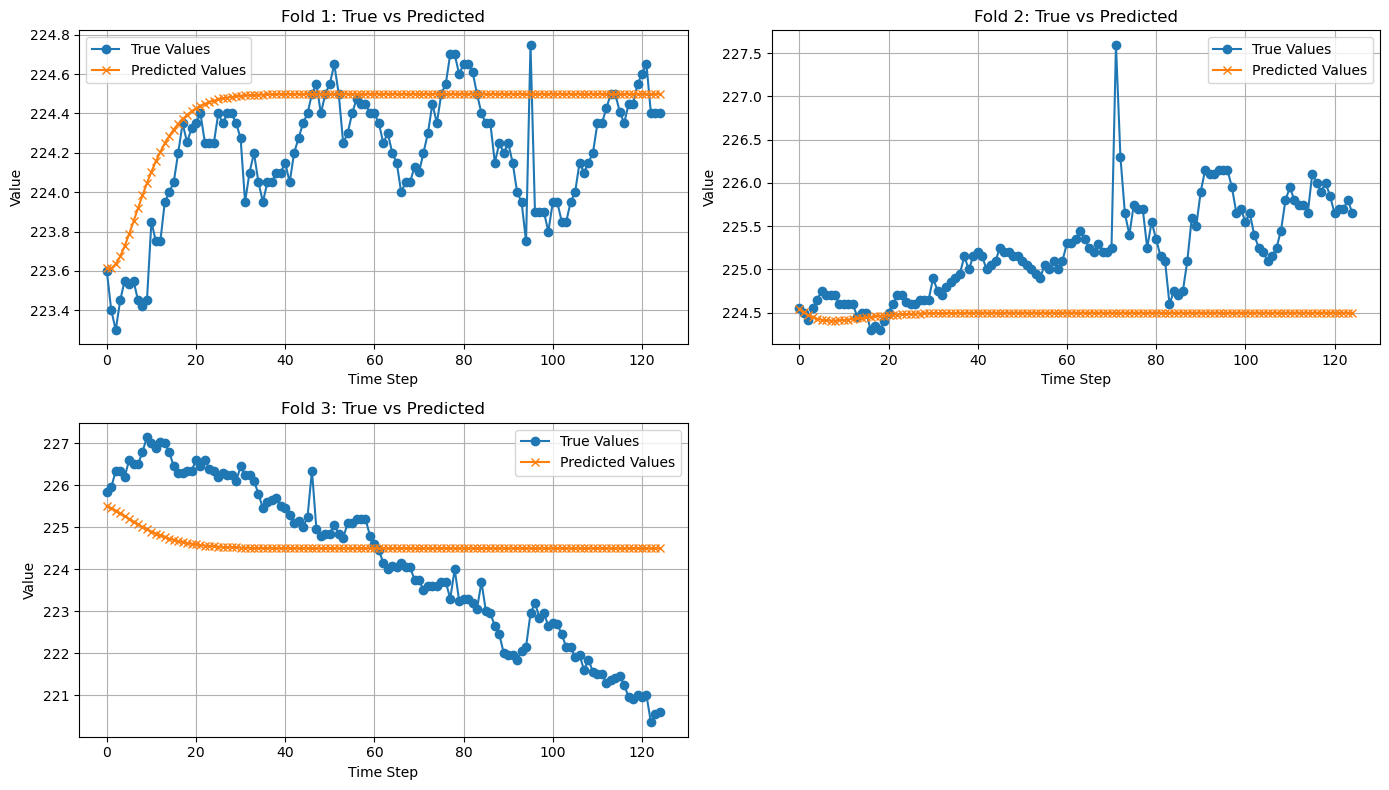

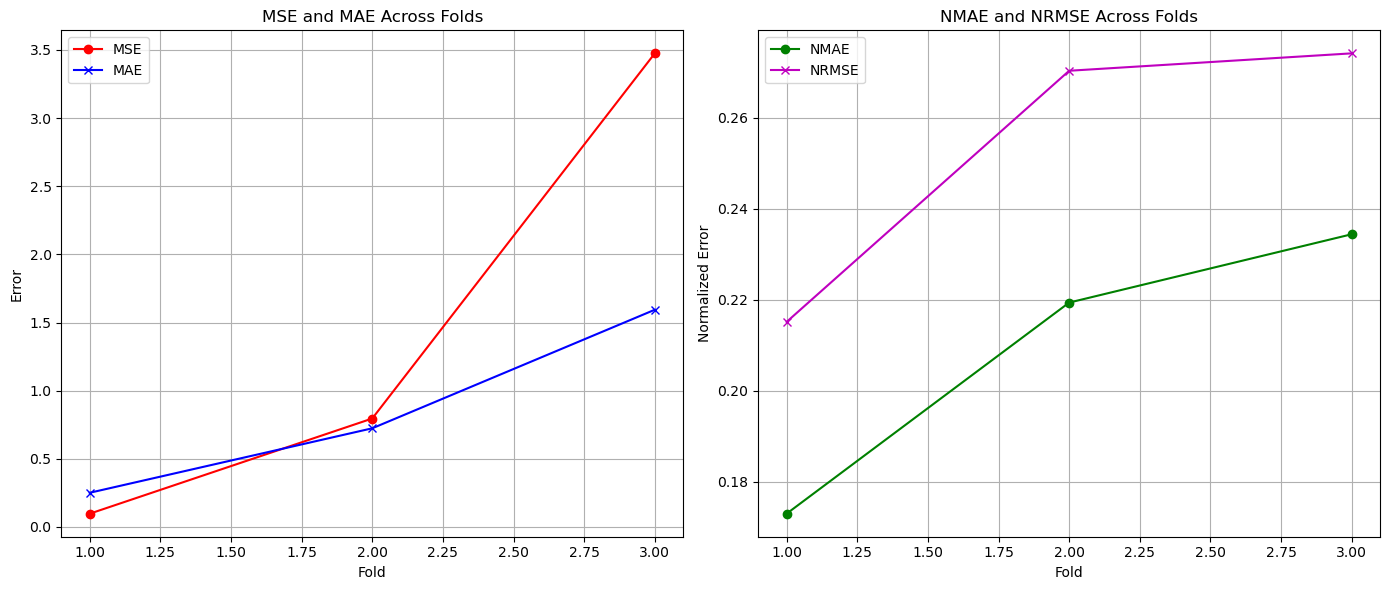


Average MSE across folds: 1.4559
Average MAE across folds: 0.8561
Average NMAE across folds: 0.2089
Average NRMSE across folds: 0.2532


In [32]:
# Plot predictions vs. actual values for each fold
plt.figure(figsize=(14, 8))
for fold in range(len(y_true_all_folds)):
    plt.subplot(2, 2, fold + 1)
    plt.plot(y_true_all_folds[fold], label='True Values', marker='o')
    plt.plot(y_pred_all_folds[fold], label='Predicted Values', marker='x')
    plt.title(f'Fold {fold + 1}: True vs Predicted')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# Plot performance metrics across folds
folds = np.arange(1, len(mse_scores) + 1)

plt.figure(figsize=(14, 6))

# Plot MSE
plt.subplot(1, 2, 1)
plt.plot(folds, mse_scores, label='MSE', marker='o', color='r')
plt.plot(folds, mae_scores, label='MAE', marker='x', color='b')
plt.title('MSE and MAE Across Folds')
plt.xlabel('Fold')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

# Plot NMAE and NRMSE
plt.subplot(1, 2, 2)
plt.plot(folds, nmae_scores, label='NMAE', marker='o', color='g')
plt.plot(folds, nrmse_scores, label='NRMSE', marker='x', color='m')
plt.title('NMAE and NRMSE Across Folds')
plt.xlabel('Fold')
plt.ylabel('Normalized Error')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Output the mean performance across all folds
print(f"\nAverage MSE across folds: {np.mean(mse_scores):.4f}")
print(f"Average MAE across folds: {np.mean(mae_scores):.4f}")
print(f"Average NMAE across folds: {np.mean(nmae_scores):.4f}")
print(f"Average NRMSE across folds: {np.mean(nrmse_scores):.4f}")

# Section 10
In this section, fixed on the previous model, we perform a rolling window prediction, updating each new point, with the real test data to make the next prediction

0.007317580833330339
0
0


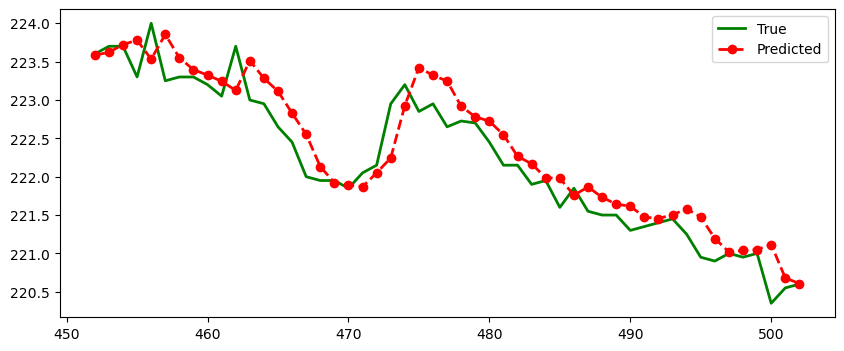

In [33]:


# Define the Matérn kernel function
def matern_kernel(x1, x2, length_scale, sigma_f, nu=0.5):
    x1 = np.atleast_2d(x1)
    x2 = np.atleast_2d(x2)
    pairwise_dists = np.sqrt(np.sum((x1[:, np.newaxis] - x2[np.newaxis, :])**2, axis=-1))
    factor = (np.sqrt(2 * nu) * pairwise_dists) / length_scale
    
    if nu == 0.5:
        K = np.exp(-factor)
    elif nu == 1.5:
        K = (1 + factor) * np.exp(-factor)
    elif nu == 2.5:
        K = (1 + factor + factor**2 / 3) * np.exp(-factor)
    else:
        K = (2 ** (1 - nu) / gamma(nu)) * (factor ** nu) * kv(nu, factor)
        
    return sigma_f**2 * K

# Define the log marginal likelihood function using the Matérn kernel with white noise kernel
def log_marginal_likelihood(params, X_train, y_train_centered, nu=0.5):
    length_scale = params[0]
    sigma_f = params[1]
    sigma_y = params[2]
    sigma_noise = params[3]
    
    # Matérn kernel + white noise kernel
    K = matern_kernel(X_train, X_train, length_scale, sigma_f, nu) + sigma_noise**2 * np.eye(len(X_train)) + sigma_y**2 * np.eye(len(X_train))
    
    # Cholesky decomposition for solving the linear system
    L = np.linalg.cholesky(K)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y_train_centered))
    
    return 0.5 * np.dot(y_train_centered.T, alpha) + np.sum(np.log(np.diag(L))) + 0.5 * len(X_train) * np.log(2 * np.pi)

# Posterior predictive function with white noise kernel
def posterior_predictive(X_train, y_train_centered, X_s, length_scale, sigma_f, sigma_y, sigma_noise, nu=0.5):
    K = matern_kernel(X_train, X_train, length_scale, sigma_f, nu) + sigma_noise**2 * np.eye(len(X_train)) + sigma_y**2 * np.eye(len(X_train))
    K_s = matern_kernel(X_train, X_s, length_scale, sigma_f, nu)
    K_ss = matern_kernel(X_s, X_s, length_scale, sigma_f, nu) + sigma_noise**2 * np.eye(len(X_s))
    K_inv = np.linalg.inv(K)

    mu_s_centered = K_s.T.dot(K_inv).dot(y_train_centered)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)

    return mu_s_centered, cov_s

# Extract input features (X) and output targets (y)
X = np.array(data.index).reshape(-1, 1)  # Using the index as the input feature for simplicity
y = data['Close'].values

# Calculate the mean of the data (for zero-centering)
mean_y = np.mean(y)

# Initialize performance metrics
mse_scores = []
mae_scores = []
nmae_scores = []
nrmse_scores = []

# Store predictions and true values for plotting
y_true_all = []
y_pred_all = []

# Start with a minimum training window size
initial_train_size = int(0.9 * len(X))  # Use the first 60% as the initial training set

for i in range(initial_train_size, len(X)):
    # Define the rolling window for training and testing
    X_train = X[:i]
    y_train = y[:i]
    X_test = X[i:i+1]  # Only one point in the test set at a time
    y_test = y[i:i+1]  # True value of the next point

    # Zero-center the y_train data
    mean_y_train = np.mean(y_train)
    y_train_centered = y_train - mean_y_train

    # Initial guesses for the hyperparameters
    initial_params = [1.0, 1.0, 1e-1, 1e-2]  # Including initial guess for sigma_noise

    # Optimize the hyperparameters (including white noise)
    res = minimize(log_marginal_likelihood, initial_params, args=(X_train, y_train_centered, 2.5), bounds=((1e-5, None), (1e-5, None), (1e-5, None), (1e-5, None)))

    # Extract optimized parameters
    length_scale_opt, sigma_f_opt, sigma_y_opt, sigma_noise_opt = res.x

    # Predict on the test set
    mu_s_centered, cov_s = posterior_predictive(X_train, y_train_centered, X_test, length_scale_opt, sigma_f_opt, sigma_y_opt, sigma_noise_opt, nu=2.5)

    # Add the constant mean back to the predictions
    mu_s = mu_s_centered + mean_y_train

    # Compute performance metrics
    mse = mean_squared_error(y_test, mu_s)
    mae = mean_absolute_error(y_test, mu_s)
    rmse = np.sqrt(mse)

    # Calculate normalization factor (you can choose between range or variance)
    range_y_test = y_test.max() - y_test.min()  # Using range for normalization

    # Compute NMAE and NRMSE
    nmae = mae / range_y_test if range_y_test != 0 else 0  # Handling edge case for zero range
    nrmse = rmse / range_y_test if range_y_test != 0 else 0

    # Store performance
    mse_scores.append(mse)
    mae_scores.append(mae)
    nmae_scores.append(nmae)
    nrmse_scores.append(nrmse)

    # Store predictions and true values
    y_true_all.append(y_test[0])
    y_pred_all.append(mu_s[0])

    
print(mae)
print(nmae)
print(nrmse)

plt.figure(figsize=(10, 4))
# Visualization of true vs predicted values
plt.plot(range(initial_train_size, len(X)), y_true_all,'g', lw=2, label='True')
plt.plot(range(initial_train_size, len(X)), y_pred_all, 'r--o', lw=2, label='Predicted')
plt.legend()
plt.show()
